In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v2'

data_save_dir = 'data'+suf

suf += '_spanbert-large-cased'

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'E-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'E-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'E-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'S-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
# stacked_embeddings = StackedEmbeddings([
#     WordEmbeddings('glove',
#                    force_cpu=False,
#                 #    embedding_length=1024,
#                   #  fine_tune=True,
#                    ),
#     # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
#     #                                    subtoken_pooling="first",
#     #                                    is_document_embedding=True,
#     #                                    fine_tune=True,
#     #                                    use_context=True,
#     #                                    max_seq_length=1024,
#     #                                    ),
#     FlairEmbeddings('news-forward',
#                     # fine_tune=True
#                     ),
#     FlairEmbeddings('news-backward',
#                     # fine_tune=True
#                     ),
# ])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md


embeddings = TransformerWordEmbeddings(model='SpanBERT/spanbert-large-cased',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       force_max_length=True,
                                      #  truncate=True, # not accepted here
                                      # #  is_document_embedding=True, # False is default
                                      #  allow_long_sentences=True, # True is default; doesnt go through
                                      #  embedding_length=512,
                                       )
# embeddings.allow_long_sentences = False
embeddings.truncate = True
# embeddings.embedding_length_internal = 512
print(embeddings.force_max_length,embeddings.truncate,embeddings.allow_long_sentences,embeddings.embedding_length_internal)
embeddings.tokenizer.model_max_length=512
print(embeddings.to_args())
print(embeddings.tokenizer)


# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        # embeddings=stacked_embeddings,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        use_crf=False,
                        use_rnn=False,
                        # reproject_embeddings=False
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 14:55:55,778 Filtering empty sentences
2023-04-21 14:55:55,812 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 14:55:55,814 Computing label dictionary. Progress:


948it [00:00, 6369.44it/s]

2023-04-21 14:55:55,971 Dictionary created for label 'ner' with 22 values: O (seen 79057 times), I-ADR (seen 4449 times), E-ADR (seen 3506 times), B-ADR (seen 3349 times), S-ADR (seen 1363 times), S-Drug (seen 1286 times), B-Finding (seen 200 times), E-Finding (seen 200 times), I-Finding (seen 149 times), B-Disease (seen 119 times), E-Disease (seen 119 times), E-Symptom (seen 114 times), S-Disease (seen 112 times), S-Symptom (seen 112 times), E-Drug (seen 111 times), B-Symptom (seen 110 times), B-Drug (seen 110 times), S-Finding (seen 109 times), I-Symptom (seen 104 times), I-Drug (seen 50 times)
False


True True False 1024
{'is_token_embedding': True, 'is_document_embedding': False, 'allow_long_sentences': False, 'tokenizer': BertTokenizerFast(name_or_path='SpanBERT/spanbert-large-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[FLERT]']}, clean_up_tokenization_spaces=True), 'context_length': 64, 'context_dropout': 0.5, 'respect_document_boundaries': True, 'truncate': True, 'stride': 0, 'embedding_length': 1024, 'name': 'transformer-SpanBERT/spanbert-large-cased', 'fine_tune': True, 'use_lang_emb': False, 'force_max_length': True, 'feature_extractor': None, 'use_context_separator': True, 'needs_manual_ocr': False}
BertTokenizerFast(name_or_path='SpanBERT/spanbert-large-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side=

In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 15,
              eval_batch_size = 15,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=5.0e-6,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 14:56:03,858 tensorboard logging path is runs/tb_logs_v2_spanbert-large-cased


/usr/local/lib/python3.9/dist-packages/flair/trainers/trainer.py:69: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-04-21 14:56:04,404 ----------------------------------------------------------------------------------------------------
2023-04-21 14:56:04,409 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28997, 1024)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-23): 24 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout)

100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


2023-04-21 14:57:41,554 Evaluating as a multi-label problem: True
2023-04-21 14:57:45,261 TRAIN : loss 1.3106995820999146 - f1-score (weighted avg)  0.0001


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]

2023-04-21 14:57:48,607 Evaluating as a multi-label problem: False
2023-04-21 14:57:48,669 DEV : loss 1.305672526359558 - f1-score (weighted avg)  0.0
2023-04-21 14:57:48,690 BAD EPOCHS (no improvement): 0
2023-04-21 14:57:48,694 saving best model


2023-04-21 14:57:57,982 ----------------------------------------------------------------------------------------------------
2023-04-21 14:58:04,798 epoch 2 - iter 6/64 - loss 1.33603308 - time (sec): 6.81 - samples/sec: 1341.90 - lr: 0.000005
2023-04-21 14:58:11,556 epoch 2 - iter 12/64 - loss 1.28680588 - time (sec): 13.57 - samples/sec: 1371.24 - lr: 0.000005
2023-04-21 14:58:18,213 epoch 2 - iter 18/64 - loss 1.29745374 - time (sec): 20.23 - samples/sec: 1304.91 - lr: 0.000005
2023-04-21 14:58:24,893 epoch 2 - iter 24/64 - loss 1.26851612 - time (sec): 26.91 - samples/sec: 1297.57 - lr: 0.000005
2023-04-21 14:58:31,584 epoch 2 - iter 30/64 - loss 1.24326455 - time (sec): 33.60 - samples/sec: 1303.06 - lr: 0.000005
2023-04-21 14:58:38,439 epoch 2 - iter 36/64 - loss 1.23533549 - time (sec): 40.45 - samples/sec: 1323.91 - lr: 0.000005
2023-04-21 14:58:45,129 epoch 2 - iter 42/64 - loss 1.22119349 - time (sec): 47.14 - samples/sec: 1328.16 - lr: 0.000005
2023-04-21 14:58:51,916 epoch 

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 14:59:33,712 Evaluating as a multi-label problem: True
2023-04-21 14:59:36,339 TRAIN : loss 0.9801037907600403 - f1-score (weighted avg)  0.0001


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 14:59:39,726 Evaluating as a multi-label problem: False
2023-04-21 14:59:39,792 DEV : loss 0.9744789004325867 - f1-score (weighted avg)  0.0
2023-04-21 14:59:39,813 BAD EPOCHS (no improvement): 0
2023-04-21 14:59:39,818 saving best model


2023-04-21 14:59:50,306 ----------------------------------------------------------------------------------------------------
2023-04-21 14:59:56,970 epoch 3 - iter 6/64 - loss 0.98570872 - time (sec): 6.66 - samples/sec: 1211.88 - lr: 0.000005
2023-04-21 15:00:03,657 epoch 3 - iter 12/64 - loss 0.94653296 - time (sec): 13.35 - samples/sec: 1255.32 - lr: 0.000005
2023-04-21 15:00:10,322 epoch 3 - iter 18/64 - loss 0.92393274 - time (sec): 20.01 - samples/sec: 1264.04 - lr: 0.000005
2023-04-21 15:00:17,050 epoch 3 - iter 24/64 - loss 0.92115932 - time (sec): 26.74 - samples/sec: 1329.25 - lr: 0.000005
2023-04-21 15:00:23,839 epoch 3 - iter 30/64 - loss 0.92733796 - time (sec): 33.53 - samples/sec: 1324.63 - lr: 0.000005
2023-04-21 15:00:30,756 epoch 3 - iter 36/64 - loss 0.94415302 - time (sec): 40.45 - samples/sec: 1347.97 - lr: 0.000005
2023-04-21 15:00:37,473 epoch 3 - iter 42/64 - loss 0.93546052 - time (sec): 47.16 - samples/sec: 1372.13 - lr: 0.000005
2023-04-21 15:00:44,293 epoch 

100%|██████████| 64/64 [00:25<00:00,  2.48it/s]


2023-04-21 15:01:27,144 Evaluating as a multi-label problem: True
2023-04-21 15:01:29,785 TRAIN : loss 0.8688046932220459 - f1-score (weighted avg)  0.0001


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:01:33,166 Evaluating as a multi-label problem: False
2023-04-21 15:01:33,233 DEV : loss 0.8662349581718445 - f1-score (weighted avg)  0.0
2023-04-21 15:01:33,255 BAD EPOCHS (no improvement): 0
2023-04-21 15:01:33,260 saving best model


2023-04-21 15:01:43,527 ----------------------------------------------------------------------------------------------------
2023-04-21 15:01:50,294 epoch 4 - iter 6/64 - loss 0.83476886 - time (sec): 6.76 - samples/sec: 1352.25 - lr: 0.000005
2023-04-21 15:01:57,006 epoch 4 - iter 12/64 - loss 0.85781116 - time (sec): 13.48 - samples/sec: 1288.42 - lr: 0.000005
2023-04-21 15:02:03,805 epoch 4 - iter 18/64 - loss 0.86118018 - time (sec): 20.28 - samples/sec: 1318.61 - lr: 0.000005
2023-04-21 15:02:10,526 epoch 4 - iter 24/64 - loss 0.84471599 - time (sec): 27.00 - samples/sec: 1336.41 - lr: 0.000005
2023-04-21 15:02:17,366 epoch 4 - iter 30/64 - loss 0.85396684 - time (sec): 33.84 - samples/sec: 1344.77 - lr: 0.000005
2023-04-21 15:02:24,021 epoch 4 - iter 36/64 - loss 0.84239807 - time (sec): 40.49 - samples/sec: 1326.85 - lr: 0.000005
2023-04-21 15:02:30,729 epoch 4 - iter 42/64 - loss 0.82701857 - time (sec): 47.20 - samples/sec: 1322.50 - lr: 0.000005
2023-04-21 15:02:37,449 epoch 

100%|██████████| 64/64 [00:25<00:00,  2.50it/s]


2023-04-21 15:03:20,258 Evaluating as a multi-label problem: True
2023-04-21 15:03:22,898 TRAIN : loss 0.6235568523406982 - f1-score (weighted avg)  0.0001


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

2023-04-21 15:03:26,268 Evaluating as a multi-label problem: False
2023-04-21 15:03:26,342 DEV : loss 0.6301484107971191 - f1-score (weighted avg)  0.0
2023-04-21 15:03:26,363 BAD EPOCHS (no improvement): 0
2023-04-21 15:03:26,367 saving best model


2023-04-21 15:03:37,587 ----------------------------------------------------------------------------------------------------
2023-04-21 15:03:44,305 epoch 5 - iter 6/64 - loss 0.64189917 - time (sec): 6.72 - samples/sec: 1271.25 - lr: 0.000005
2023-04-21 15:03:51,071 epoch 5 - iter 12/64 - loss 0.64165897 - time (sec): 13.48 - samples/sec: 1321.05 - lr: 0.000005
2023-04-21 15:03:57,915 epoch 5 - iter 18/64 - loss 0.67020753 - time (sec): 20.33 - samples/sec: 1272.20 - lr: 0.000005
2023-04-21 15:04:04,706 epoch 5 - iter 24/64 - loss 0.65889479 - time (sec): 27.12 - samples/sec: 1319.02 - lr: 0.000005
2023-04-21 15:04:11,412 epoch 5 - iter 30/64 - loss 0.64833348 - time (sec): 33.82 - samples/sec: 1306.16 - lr: 0.000005
2023-04-21 15:04:18,099 epoch 5 - iter 36/64 - loss 0.63512917 - time (sec): 40.51 - samples/sec: 1314.62 - lr: 0.000005
2023-04-21 15:04:24,792 epoch 5 - iter 42/64 - loss 0.61736846 - time (sec): 47.20 - samples/sec: 1342.86 - lr: 0.000005
2023-04-21 15:04:31,554 epoch 

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 15:05:13,411 Evaluating as a multi-label problem: True
2023-04-21 15:05:17,203 TRAIN : loss 0.527245819568634 - f1-score (weighted avg)  0.2602


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:05:20,607 Evaluating as a multi-label problem: False
2023-04-21 15:05:20,679 DEV : loss 0.5404419302940369 - f1-score (weighted avg)  0.2488
2023-04-21 15:05:20,701 BAD EPOCHS (no improvement): 0
2023-04-21 15:05:20,705 saving best model


2023-04-21 15:05:30,835 ----------------------------------------------------------------------------------------------------
2023-04-21 15:05:37,558 epoch 6 - iter 6/64 - loss 0.56890558 - time (sec): 6.72 - samples/sec: 1175.72 - lr: 0.000005
2023-04-21 15:05:44,214 epoch 6 - iter 12/64 - loss 0.55692723 - time (sec): 13.38 - samples/sec: 1284.38 - lr: 0.000005
2023-04-21 15:05:51,008 epoch 6 - iter 18/64 - loss 0.53666869 - time (sec): 20.17 - samples/sec: 1324.53 - lr: 0.000005
2023-04-21 15:05:57,708 epoch 6 - iter 24/64 - loss 0.52640795 - time (sec): 26.87 - samples/sec: 1360.73 - lr: 0.000005
2023-04-21 15:06:04,458 epoch 6 - iter 30/64 - loss 0.52323205 - time (sec): 33.62 - samples/sec: 1386.41 - lr: 0.000005
2023-04-21 15:06:11,228 epoch 6 - iter 36/64 - loss 0.51630565 - time (sec): 40.39 - samples/sec: 1386.08 - lr: 0.000005
2023-04-21 15:06:17,973 epoch 6 - iter 42/64 - loss 0.51275128 - time (sec): 47.13 - samples/sec: 1372.84 - lr: 0.000005
2023-04-21 15:06:24,629 epoch 

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 15:07:06,714 Evaluating as a multi-label problem: True
2023-04-21 15:07:10,556 TRAIN : loss 0.4584510326385498 - f1-score (weighted avg)  0.4274


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:07:13,948 Evaluating as a multi-label problem: False
2023-04-21 15:07:14,014 DEV : loss 0.48442408442497253 - f1-score (weighted avg)  0.397
2023-04-21 15:07:14,037 BAD EPOCHS (no improvement): 0
2023-04-21 15:07:14,041 saving best model


2023-04-21 15:07:25,754 ----------------------------------------------------------------------------------------------------
2023-04-21 15:07:32,466 epoch 7 - iter 6/64 - loss 0.46197731 - time (sec): 6.71 - samples/sec: 1288.18 - lr: 0.000005
2023-04-21 15:07:39,204 epoch 7 - iter 12/64 - loss 0.45065659 - time (sec): 13.45 - samples/sec: 1259.86 - lr: 0.000005
2023-04-21 15:07:45,906 epoch 7 - iter 18/64 - loss 0.46680728 - time (sec): 20.15 - samples/sec: 1283.22 - lr: 0.000005
2023-04-21 15:07:52,718 epoch 7 - iter 24/64 - loss 0.46761208 - time (sec): 26.96 - samples/sec: 1329.89 - lr: 0.000005
2023-04-21 15:07:59,399 epoch 7 - iter 30/64 - loss 0.46536453 - time (sec): 33.64 - samples/sec: 1310.42 - lr: 0.000005
2023-04-21 15:08:06,158 epoch 7 - iter 36/64 - loss 0.45927458 - time (sec): 40.40 - samples/sec: 1321.46 - lr: 0.000005
2023-04-21 15:08:13,024 epoch 7 - iter 42/64 - loss 0.46790830 - time (sec): 47.27 - samples/sec: 1345.88 - lr: 0.000005
2023-04-21 15:08:19,737 epoch 

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 15:09:01,613 Evaluating as a multi-label problem: True
2023-04-21 15:09:04,469 TRAIN : loss 0.3886544406414032 - f1-score (weighted avg)  0.5102


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:09:07,869 Evaluating as a multi-label problem: False
2023-04-21 15:09:07,936 DEV : loss 0.4294235408306122 - f1-score (weighted avg)  0.4372
2023-04-21 15:09:07,957 BAD EPOCHS (no improvement): 0
2023-04-21 15:09:07,961 saving best model


2023-04-21 15:09:18,245 ----------------------------------------------------------------------------------------------------
2023-04-21 15:09:24,959 epoch 8 - iter 6/64 - loss 0.40626142 - time (sec): 6.71 - samples/sec: 1379.26 - lr: 0.000005
2023-04-21 15:09:31,643 epoch 8 - iter 12/64 - loss 0.40624815 - time (sec): 13.40 - samples/sec: 1347.69 - lr: 0.000005
2023-04-21 15:09:38,582 epoch 8 - iter 18/64 - loss 0.42924466 - time (sec): 20.34 - samples/sec: 1373.17 - lr: 0.000005
2023-04-21 15:09:45,270 epoch 8 - iter 24/64 - loss 0.41517193 - time (sec): 27.02 - samples/sec: 1336.39 - lr: 0.000005
2023-04-21 15:09:52,045 epoch 8 - iter 30/64 - loss 0.41377540 - time (sec): 33.80 - samples/sec: 1338.91 - lr: 0.000005
2023-04-21 15:09:58,715 epoch 8 - iter 36/64 - loss 0.41083631 - time (sec): 40.47 - samples/sec: 1314.62 - lr: 0.000005
2023-04-21 15:10:05,410 epoch 8 - iter 42/64 - loss 0.40334432 - time (sec): 47.16 - samples/sec: 1304.47 - lr: 0.000005
2023-04-21 15:10:12,119 epoch 

100%|██████████| 64/64 [00:25<00:00,  2.48it/s]


2023-04-21 15:10:55,214 Evaluating as a multi-label problem: True
2023-04-21 15:10:59,087 TRAIN : loss 0.3294545114040375 - f1-score (weighted avg)  0.6105


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

2023-04-21 15:11:02,455 Evaluating as a multi-label problem: False
2023-04-21 15:11:02,529 DEV : loss 0.3896329402923584 - f1-score (weighted avg)  0.5163
2023-04-21 15:11:02,550 BAD EPOCHS (no improvement): 0
2023-04-21 15:11:02,555 saving best model


2023-04-21 15:11:12,270 ----------------------------------------------------------------------------------------------------
2023-04-21 15:11:18,968 epoch 9 - iter 6/64 - loss 0.34897522 - time (sec): 6.70 - samples/sec: 1214.03 - lr: 0.000005
2023-04-21 15:11:25,752 epoch 9 - iter 12/64 - loss 0.34330558 - time (sec): 13.48 - samples/sec: 1359.85 - lr: 0.000005
2023-04-21 15:11:32,596 epoch 9 - iter 18/64 - loss 0.36722092 - time (sec): 20.32 - samples/sec: 1397.39 - lr: 0.000005
2023-04-21 15:11:39,320 epoch 9 - iter 24/64 - loss 0.36030415 - time (sec): 27.05 - samples/sec: 1345.56 - lr: 0.000005
2023-04-21 15:11:46,047 epoch 9 - iter 30/64 - loss 0.34910217 - time (sec): 33.77 - samples/sec: 1371.14 - lr: 0.000005
2023-04-21 15:11:52,758 epoch 9 - iter 36/64 - loss 0.34559488 - time (sec): 40.49 - samples/sec: 1359.88 - lr: 0.000005
2023-04-21 15:11:59,559 epoch 9 - iter 42/64 - loss 0.34846104 - time (sec): 47.29 - samples/sec: 1365.81 - lr: 0.000005
2023-04-21 15:12:06,256 epoch 

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


2023-04-21 15:12:48,278 Evaluating as a multi-label problem: True
2023-04-21 15:12:52,290 TRAIN : loss 0.28942999243736267 - f1-score (weighted avg)  0.7048


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

2023-04-21 15:12:55,658 Evaluating as a multi-label problem: False
2023-04-21 15:12:55,728 DEV : loss 0.3671266436576843 - f1-score (weighted avg)  0.604
2023-04-21 15:12:55,749 BAD EPOCHS (no improvement): 0
2023-04-21 15:12:55,753 saving best model


2023-04-21 15:13:05,346 ----------------------------------------------------------------------------------------------------
2023-04-21 15:13:12,067 epoch 10 - iter 6/64 - loss 0.31070939 - time (sec): 6.72 - samples/sec: 1343.28 - lr: 0.000005
2023-04-21 15:13:18,850 epoch 10 - iter 12/64 - loss 0.31347606 - time (sec): 13.50 - samples/sec: 1400.77 - lr: 0.000005
2023-04-21 15:13:25,508 epoch 10 - iter 18/64 - loss 0.31279389 - time (sec): 20.16 - samples/sec: 1344.68 - lr: 0.000005
2023-04-21 15:13:32,178 epoch 10 - iter 24/64 - loss 0.30872141 - time (sec): 26.83 - samples/sec: 1322.83 - lr: 0.000005
2023-04-21 15:13:38,847 epoch 10 - iter 30/64 - loss 0.29998883 - time (sec): 33.50 - samples/sec: 1316.90 - lr: 0.000005
2023-04-21 15:13:45,678 epoch 10 - iter 36/64 - loss 0.31661349 - time (sec): 40.33 - samples/sec: 1327.75 - lr: 0.000005
2023-04-21 15:13:52,347 epoch 10 - iter 42/64 - loss 0.31182225 - time (sec): 47.00 - samples/sec: 1324.88 - lr: 0.000005
2023-04-21 15:13:59,155

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


2023-04-21 15:14:41,230 Evaluating as a multi-label problem: True
2023-04-21 15:14:43,972 TRAIN : loss 0.2574145793914795 - f1-score (weighted avg)  0.7427


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

2023-04-21 15:14:47,338 Evaluating as a multi-label problem: False
2023-04-21 15:14:47,408 DEV : loss 0.35706833004951477 - f1-score (weighted avg)  0.6324
2023-04-21 15:14:47,428 BAD EPOCHS (no improvement): 0
2023-04-21 15:14:47,432 saving best model


2023-04-21 15:14:57,441 ----------------------------------------------------------------------------------------------------
2023-04-21 15:15:04,306 epoch 11 - iter 6/64 - loss 0.30564832 - time (sec): 6.86 - samples/sec: 1455.17 - lr: 0.000005
2023-04-21 15:15:11,018 epoch 11 - iter 12/64 - loss 0.28194098 - time (sec): 13.57 - samples/sec: 1344.14 - lr: 0.000005
2023-04-21 15:15:17,679 epoch 11 - iter 18/64 - loss 0.27977207 - time (sec): 20.24 - samples/sec: 1320.58 - lr: 0.000005
2023-04-21 15:15:24,343 epoch 11 - iter 24/64 - loss 0.28029822 - time (sec): 26.90 - samples/sec: 1334.91 - lr: 0.000005
2023-04-21 15:15:31,077 epoch 11 - iter 30/64 - loss 0.27001259 - time (sec): 33.63 - samples/sec: 1345.72 - lr: 0.000005
2023-04-21 15:15:37,801 epoch 11 - iter 36/64 - loss 0.26540711 - time (sec): 40.36 - samples/sec: 1332.73 - lr: 0.000005
2023-04-21 15:15:45,521 epoch 11 - iter 42/64 - loss 0.26706012 - time (sec): 48.08 - samples/sec: 1310.09 - lr: 0.000005
2023-04-21 15:15:52,216

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:16:34,360 Evaluating as a multi-label problem: True
2023-04-21 15:16:38,244 TRAIN : loss 0.23602625727653503 - f1-score (weighted avg)  0.7522


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:16:41,643 Evaluating as a multi-label problem: False
2023-04-21 15:16:41,714 DEV : loss 0.3434412181377411 - f1-score (weighted avg)  0.6371
2023-04-21 15:16:41,737 BAD EPOCHS (no improvement): 0
2023-04-21 15:16:41,741 saving best model


2023-04-21 15:16:51,187 ----------------------------------------------------------------------------------------------------
2023-04-21 15:16:57,899 epoch 12 - iter 6/64 - loss 0.23931080 - time (sec): 6.71 - samples/sec: 1292.80 - lr: 0.000005
2023-04-21 15:17:04,583 epoch 12 - iter 12/64 - loss 0.23948579 - time (sec): 13.39 - samples/sec: 1247.28 - lr: 0.000005
2023-04-21 15:17:11,540 epoch 12 - iter 18/64 - loss 0.30055898 - time (sec): 20.35 - samples/sec: 1296.71 - lr: 0.000005
2023-04-21 15:17:18,215 epoch 12 - iter 24/64 - loss 0.29330624 - time (sec): 27.03 - samples/sec: 1274.22 - lr: 0.000005
2023-04-21 15:17:25,006 epoch 12 - iter 30/64 - loss 0.28472687 - time (sec): 33.82 - samples/sec: 1294.48 - lr: 0.000005
2023-04-21 15:17:31,691 epoch 12 - iter 36/64 - loss 0.27282329 - time (sec): 40.50 - samples/sec: 1314.88 - lr: 0.000005
2023-04-21 15:17:38,435 epoch 12 - iter 42/64 - loss 0.26293625 - time (sec): 47.25 - samples/sec: 1328.82 - lr: 0.000005
2023-04-21 15:17:45,156

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:18:27,176 Evaluating as a multi-label problem: True
2023-04-21 15:18:31,130 TRAIN : loss 0.21483080089092255 - f1-score (weighted avg)  0.7673


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:18:34,529 Evaluating as a multi-label problem: False
2023-04-21 15:18:34,600 DEV : loss 0.33488979935646057 - f1-score (weighted avg)  0.6326
2023-04-21 15:18:34,621 BAD EPOCHS (no improvement): 0
2023-04-21 15:18:34,625 saving best model


2023-04-21 15:18:44,903 ----------------------------------------------------------------------------------------------------
2023-04-21 15:18:51,595 epoch 13 - iter 6/64 - loss 0.20847284 - time (sec): 6.69 - samples/sec: 1360.34 - lr: 0.000005
2023-04-21 15:18:58,409 epoch 13 - iter 12/64 - loss 0.21190554 - time (sec): 13.50 - samples/sec: 1390.51 - lr: 0.000005
2023-04-21 15:19:05,075 epoch 13 - iter 18/64 - loss 0.21141206 - time (sec): 20.17 - samples/sec: 1362.21 - lr: 0.000005
2023-04-21 15:19:11,786 epoch 13 - iter 24/64 - loss 0.21950593 - time (sec): 26.88 - samples/sec: 1333.47 - lr: 0.000005
2023-04-21 15:19:18,462 epoch 13 - iter 30/64 - loss 0.21810185 - time (sec): 33.56 - samples/sec: 1305.93 - lr: 0.000005
2023-04-21 15:19:25,141 epoch 13 - iter 36/64 - loss 0.21779225 - time (sec): 40.24 - samples/sec: 1285.75 - lr: 0.000005
2023-04-21 15:19:31,867 epoch 13 - iter 42/64 - loss 0.21725054 - time (sec): 46.96 - samples/sec: 1309.86 - lr: 0.000005
2023-04-21 15:19:38,688

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


2023-04-21 15:20:20,915 Evaluating as a multi-label problem: True
2023-04-21 15:20:23,627 TRAIN : loss 0.20050732791423798 - f1-score (weighted avg)  0.7741


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


2023-04-21 15:20:28,029 Evaluating as a multi-label problem: False
2023-04-21 15:20:28,099 DEV : loss 0.3598255515098572 - f1-score (weighted avg)  0.6272
2023-04-21 15:20:28,121 BAD EPOCHS (no improvement): 1
2023-04-21 15:20:28,125 ----------------------------------------------------------------------------------------------------
2023-04-21 15:20:34,875 epoch 14 - iter 6/64 - loss 0.22765681 - time (sec): 6.75 - samples/sec: 1340.33 - lr: 0.000005
2023-04-21 15:20:41,581 epoch 14 - iter 12/64 - loss 0.20539010 - time (sec): 13.45 - samples/sec: 1341.77 - lr: 0.000005
2023-04-21 15:20:48,265 epoch 14 - iter 18/64 - loss 0.21240241 - time (sec): 20.14 - samples/sec: 1322.82 - lr: 0.000005
2023-04-21 15:20:54,958 epoch 14 - iter 24/64 - loss 0.21182007 - time (sec): 26.83 - samples/sec: 1325.92 - lr: 0.000005
2023-04-21 15:21:01,647 epoch 14 - iter 30/64 - loss 0.20986812 - time (sec): 33.52 - samples/sec: 1323.85 - lr: 0.000005
2023-04-21 15:21:08,388 epoch 14 - iter 36/64 - loss 0.21

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:22:04,052 Evaluating as a multi-label problem: True
2023-04-21 15:22:08,006 TRAIN : loss 0.18805454671382904 - f1-score (weighted avg)  0.7824


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:22:11,406 Evaluating as a multi-label problem: False
2023-04-21 15:22:11,475 DEV : loss 0.33287736773490906 - f1-score (weighted avg)  0.6272
2023-04-21 15:22:11,496 BAD EPOCHS (no improvement): 0
2023-04-21 15:22:11,500 saving best model


2023-04-21 15:22:21,192 ----------------------------------------------------------------------------------------------------
2023-04-21 15:22:27,936 epoch 15 - iter 6/64 - loss 0.19823804 - time (sec): 6.74 - samples/sec: 1254.69 - lr: 0.000005
2023-04-21 15:22:34,831 epoch 15 - iter 12/64 - loss 0.21445966 - time (sec): 13.64 - samples/sec: 1303.03 - lr: 0.000005
2023-04-21 15:22:41,535 epoch 15 - iter 18/64 - loss 0.20060552 - time (sec): 20.34 - samples/sec: 1278.93 - lr: 0.000005
2023-04-21 15:22:48,446 epoch 15 - iter 24/64 - loss 0.22524695 - time (sec): 27.25 - samples/sec: 1313.30 - lr: 0.000005
2023-04-21 15:22:55,143 epoch 15 - iter 30/64 - loss 0.22088385 - time (sec): 33.95 - samples/sec: 1290.53 - lr: 0.000005
2023-04-21 15:23:01,852 epoch 15 - iter 36/64 - loss 0.21542389 - time (sec): 40.66 - samples/sec: 1289.88 - lr: 0.000005
2023-04-21 15:23:08,580 epoch 15 - iter 42/64 - loss 0.21216370 - time (sec): 47.39 - samples/sec: 1326.27 - lr: 0.000005
2023-04-21 15:23:15,269

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


2023-04-21 15:23:57,402 Evaluating as a multi-label problem: True
2023-04-21 15:24:01,352 TRAIN : loss 0.18198886513710022 - f1-score (weighted avg)  0.7836


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:24:04,740 Evaluating as a multi-label problem: False
2023-04-21 15:24:04,813 DEV : loss 0.3354378342628479 - f1-score (weighted avg)  0.6286
2023-04-21 15:24:04,834 BAD EPOCHS (no improvement): 1
2023-04-21 15:24:04,839 ----------------------------------------------------------------------------------------------------


2023-04-21 15:24:11,545 epoch 16 - iter 6/64 - loss 0.18717252 - time (sec): 6.70 - samples/sec: 1332.29 - lr: 0.000005
2023-04-21 15:24:18,275 epoch 16 - iter 12/64 - loss 0.19987973 - time (sec): 13.43 - samples/sec: 1329.22 - lr: 0.000005
2023-04-21 15:24:25,112 epoch 16 - iter 18/64 - loss 0.22905987 - time (sec): 20.27 - samples/sec: 1325.12 - lr: 0.000005
2023-04-21 15:24:31,836 epoch 16 - iter 24/64 - loss 0.21463242 - time (sec): 27.00 - samples/sec: 1372.20 - lr: 0.000005
2023-04-21 15:24:38,612 epoch 16 - iter 30/64 - loss 0.21857972 - time (sec): 33.77 - samples/sec: 1368.32 - lr: 0.000005
2023-04-21 15:24:45,304 epoch 16 - iter 36/64 - loss 0.21282021 - time (sec): 40.46 - samples/sec: 1346.24 - lr: 0.000005
2023-04-21 15:24:51,981 epoch 16 - iter 42/64 - loss 0.20849913 - time (sec): 47.14 - samples/sec: 1338.82 - lr: 0.000005
2023-04-21 15:24:58,691 epoch 16 - iter 48/64 - loss 0.20254008 - time (sec): 53.85 - samples/sec: 1343.47 - lr: 0.000005
2023-04-21 15:25:05,407 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:25:40,642 Evaluating as a multi-label problem: True
2023-04-21 15:25:43,364 TRAIN : loss 0.1684892773628235 - f1-score (weighted avg)  0.7916


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

2023-04-21 15:25:47,770 Evaluating as a multi-label problem: False
2023-04-21 15:25:47,840 DEV : loss 0.3369958996772766 - f1-score (weighted avg)  0.6381
2023-04-21 15:25:47,862 Epoch    16: reducing learning rate of group 0 to 2.5000e-06.
2023-04-21 15:25:47,864 BAD EPOCHS (no improvement): 2
2023-04-21 15:25:47,868 ----------------------------------------------------------------------------------------------------


2023-04-21 15:25:54,526 epoch 17 - iter 6/64 - loss 0.16495951 - time (sec): 6.66 - samples/sec: 1206.02 - lr: 0.000003
2023-04-21 15:26:01,300 epoch 17 - iter 12/64 - loss 0.16613855 - time (sec): 13.43 - samples/sec: 1348.09 - lr: 0.000003
2023-04-21 15:26:08,035 epoch 17 - iter 18/64 - loss 0.16684907 - time (sec): 20.17 - samples/sec: 1364.06 - lr: 0.000003
2023-04-21 15:26:14,720 epoch 17 - iter 24/64 - loss 0.16697916 - time (sec): 26.85 - samples/sec: 1341.27 - lr: 0.000003
2023-04-21 15:26:21,422 epoch 17 - iter 30/64 - loss 0.16840034 - time (sec): 33.55 - samples/sec: 1321.31 - lr: 0.000003
2023-04-21 15:26:28,108 epoch 17 - iter 36/64 - loss 0.16634961 - time (sec): 40.24 - samples/sec: 1293.49 - lr: 0.000003
2023-04-21 15:26:34,799 epoch 17 - iter 42/64 - loss 0.16592353 - time (sec): 46.93 - samples/sec: 1293.93 - lr: 0.000003
2023-04-21 15:26:41,521 epoch 17 - iter 48/64 - loss 0.16532292 - time (sec): 53.65 - samples/sec: 1307.66 - lr: 0.000003
2023-04-21 15:26:48,236 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:27:23,736 Evaluating as a multi-label problem: True
2023-04-21 15:27:27,616 TRAIN : loss 0.16132107377052307 - f1-score (weighted avg)  0.7948


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:27:30,998 Evaluating as a multi-label problem: False
2023-04-21 15:27:31,066 DEV : loss 0.328365683555603 - f1-score (weighted avg)  0.6335
2023-04-21 15:27:31,087 BAD EPOCHS (no improvement): 0
2023-04-21 15:27:31,091 saving best model


2023-04-21 15:27:41,038 ----------------------------------------------------------------------------------------------------
2023-04-21 15:27:47,745 epoch 18 - iter 6/64 - loss 0.18048938 - time (sec): 6.70 - samples/sec: 1191.81 - lr: 0.000003
2023-04-21 15:27:54,460 epoch 18 - iter 12/64 - loss 0.16760785 - time (sec): 13.42 - samples/sec: 1265.14 - lr: 0.000003
2023-04-21 15:28:01,148 epoch 18 - iter 18/64 - loss 0.16707931 - time (sec): 20.11 - samples/sec: 1265.70 - lr: 0.000003
2023-04-21 15:28:07,859 epoch 18 - iter 24/64 - loss 0.16179826 - time (sec): 26.82 - samples/sec: 1296.92 - lr: 0.000003
2023-04-21 15:28:14,679 epoch 18 - iter 30/64 - loss 0.16717468 - time (sec): 33.64 - samples/sec: 1351.62 - lr: 0.000003
2023-04-21 15:28:21,397 epoch 18 - iter 36/64 - loss 0.16393035 - time (sec): 40.36 - samples/sec: 1353.16 - lr: 0.000003
2023-04-21 15:28:28,273 epoch 18 - iter 42/64 - loss 0.17973566 - time (sec): 47.23 - samples/sec: 1338.07 - lr: 0.000003
2023-04-21 15:28:34,990

100%|██████████| 64/64 [00:25<00:00,  2.56it/s]


2023-04-21 15:29:17,322 Evaluating as a multi-label problem: True
2023-04-21 15:29:21,445 TRAIN : loss 0.15461769700050354 - f1-score (weighted avg)  0.7998


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:29:24,855 Evaluating as a multi-label problem: False
2023-04-21 15:29:24,927 DEV : loss 0.33131614327430725 - f1-score (weighted avg)  0.6339
2023-04-21 15:29:24,949 BAD EPOCHS (no improvement): 1
2023-04-21 15:29:24,954 ----------------------------------------------------------------------------------------------------


2023-04-21 15:29:31,667 epoch 19 - iter 6/64 - loss 0.16640238 - time (sec): 6.71 - samples/sec: 1127.11 - lr: 0.000003
2023-04-21 15:29:38,359 epoch 19 - iter 12/64 - loss 0.16096480 - time (sec): 13.40 - samples/sec: 1200.65 - lr: 0.000003
2023-04-21 15:29:45,106 epoch 19 - iter 18/64 - loss 0.15055039 - time (sec): 20.15 - samples/sec: 1282.26 - lr: 0.000003
2023-04-21 15:29:51,887 epoch 19 - iter 24/64 - loss 0.15291720 - time (sec): 26.93 - samples/sec: 1322.24 - lr: 0.000003
2023-04-21 15:29:58,562 epoch 19 - iter 30/64 - loss 0.15255188 - time (sec): 33.61 - samples/sec: 1291.73 - lr: 0.000003
2023-04-21 15:30:05,275 epoch 19 - iter 36/64 - loss 0.15586052 - time (sec): 40.32 - samples/sec: 1329.92 - lr: 0.000003
2023-04-21 15:30:11,942 epoch 19 - iter 42/64 - loss 0.15605982 - time (sec): 46.99 - samples/sec: 1306.99 - lr: 0.000003
2023-04-21 15:30:18,749 epoch 19 - iter 48/64 - loss 0.16083071 - time (sec): 53.79 - samples/sec: 1328.06 - lr: 0.000003
2023-04-21 15:30:25,611 ep

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 15:31:00,784 Evaluating as a multi-label problem: True
2023-04-21 15:31:04,681 TRAIN : loss 0.15391214191913605 - f1-score (weighted avg)  0.7992


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

2023-04-21 15:31:08,089 Evaluating as a multi-label problem: False
2023-04-21 15:31:08,159 DEV : loss 0.32777702808380127 - f1-score (weighted avg)  0.6338
2023-04-21 15:31:08,181 BAD EPOCHS (no improvement): 0
2023-04-21 15:31:08,185 saving best model


2023-04-21 15:31:18,204 ----------------------------------------------------------------------------------------------------
2023-04-21 15:31:24,960 epoch 20 - iter 6/64 - loss 0.14271126 - time (sec): 6.75 - samples/sec: 1306.94 - lr: 0.000003
2023-04-21 15:31:31,639 epoch 20 - iter 12/64 - loss 0.15585020 - time (sec): 13.43 - samples/sec: 1278.05 - lr: 0.000003
2023-04-21 15:31:38,307 epoch 20 - iter 18/64 - loss 0.15594884 - time (sec): 20.10 - samples/sec: 1283.08 - lr: 0.000003
2023-04-21 15:31:44,988 epoch 20 - iter 24/64 - loss 0.15455928 - time (sec): 26.78 - samples/sec: 1300.83 - lr: 0.000003
2023-04-21 15:31:51,726 epoch 20 - iter 30/64 - loss 0.14662873 - time (sec): 33.52 - samples/sec: 1309.15 - lr: 0.000003
2023-04-21 15:31:58,563 epoch 20 - iter 36/64 - loss 0.15358836 - time (sec): 40.36 - samples/sec: 1328.99 - lr: 0.000003
2023-04-21 15:32:05,317 epoch 20 - iter 42/64 - loss 0.15448412 - time (sec): 47.11 - samples/sec: 1326.00 - lr: 0.000003
2023-04-21 15:32:12,033

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


2023-04-21 15:32:54,279 Evaluating as a multi-label problem: True
2023-04-21 15:32:57,007 TRAIN : loss 0.14464759826660156 - f1-score (weighted avg)  0.8127


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:33:00,420 Evaluating as a multi-label problem: False
2023-04-21 15:33:00,489 DEV : loss 0.3325453996658325 - f1-score (weighted avg)  0.6441
2023-04-21 15:33:00,510 BAD EPOCHS (no improvement): 1
2023-04-21 15:33:00,514 ----------------------------------------------------------------------------------------------------


2023-04-21 15:33:07,365 epoch 21 - iter 6/64 - loss 0.17217422 - time (sec): 6.85 - samples/sec: 1402.68 - lr: 0.000003
2023-04-21 15:33:14,058 epoch 21 - iter 12/64 - loss 0.15335210 - time (sec): 13.54 - samples/sec: 1343.61 - lr: 0.000003
2023-04-21 15:33:20,752 epoch 21 - iter 18/64 - loss 0.16032620 - time (sec): 20.24 - samples/sec: 1292.54 - lr: 0.000003
2023-04-21 15:33:27,534 epoch 21 - iter 24/64 - loss 0.16199702 - time (sec): 27.02 - samples/sec: 1312.96 - lr: 0.000003
2023-04-21 15:33:34,214 epoch 21 - iter 30/64 - loss 0.15932650 - time (sec): 33.70 - samples/sec: 1297.45 - lr: 0.000003
2023-04-21 15:33:40,918 epoch 21 - iter 36/64 - loss 0.15510179 - time (sec): 40.40 - samples/sec: 1313.69 - lr: 0.000003
2023-04-21 15:33:47,602 epoch 21 - iter 42/64 - loss 0.15181310 - time (sec): 47.09 - samples/sec: 1307.75 - lr: 0.000003
2023-04-21 15:33:55,478 epoch 21 - iter 48/64 - loss 0.16738824 - time (sec): 54.96 - samples/sec: 1303.93 - lr: 0.000003
2023-04-21 15:34:02,258 ep

100%|██████████| 64/64 [00:24<00:00,  2.56it/s]


2023-04-21 15:34:37,741 Evaluating as a multi-label problem: True
2023-04-21 15:34:41,915 TRAIN : loss 0.14014171063899994 - f1-score (weighted avg)  0.8244


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

2023-04-21 15:34:45,393 Evaluating as a multi-label problem: False
2023-04-21 15:34:45,468 DEV : loss 0.3306526839733124 - f1-score (weighted avg)  0.6489
2023-04-21 15:34:45,490 Epoch    21: reducing learning rate of group 0 to 1.2500e-06.
2023-04-21 15:34:45,492 BAD EPOCHS (no improvement): 2
2023-04-21 15:34:45,497 ----------------------------------------------------------------------------------------------------


2023-04-21 15:34:52,203 epoch 22 - iter 6/64 - loss 0.11353155 - time (sec): 6.70 - samples/sec: 1242.85 - lr: 0.000001
2023-04-21 15:34:58,902 epoch 22 - iter 12/64 - loss 0.13448182 - time (sec): 13.40 - samples/sec: 1227.41 - lr: 0.000001
2023-04-21 15:35:05,708 epoch 22 - iter 18/64 - loss 0.14159776 - time (sec): 20.21 - samples/sec: 1338.95 - lr: 0.000001
2023-04-21 15:35:12,525 epoch 22 - iter 24/64 - loss 0.14168050 - time (sec): 27.03 - samples/sec: 1335.16 - lr: 0.000001
2023-04-21 15:35:19,390 epoch 22 - iter 30/64 - loss 0.16542412 - time (sec): 33.89 - samples/sec: 1333.94 - lr: 0.000001
2023-04-21 15:35:26,115 epoch 22 - iter 36/64 - loss 0.16091051 - time (sec): 40.62 - samples/sec: 1334.13 - lr: 0.000001
2023-04-21 15:35:32,825 epoch 22 - iter 42/64 - loss 0.15711232 - time (sec): 47.33 - samples/sec: 1358.22 - lr: 0.000001
2023-04-21 15:35:39,553 epoch 22 - iter 48/64 - loss 0.15634466 - time (sec): 54.06 - samples/sec: 1361.37 - lr: 0.000001
2023-04-21 15:35:46,238 ep

100%|██████████| 64/64 [00:24<00:00,  2.59it/s]


2023-04-21 15:36:21,442 Evaluating as a multi-label problem: True
2023-04-21 15:36:25,401 TRAIN : loss 0.1375254988670349 - f1-score (weighted avg)  0.828


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:36:28,796 Evaluating as a multi-label problem: False
2023-04-21 15:36:28,865 DEV : loss 0.3337743282318115 - f1-score (weighted avg)  0.6521
2023-04-21 15:36:28,886 BAD EPOCHS (no improvement): 1
2023-04-21 15:36:28,891 ----------------------------------------------------------------------------------------------------


2023-04-21 15:36:35,552 epoch 23 - iter 6/64 - loss 0.13558789 - time (sec): 6.66 - samples/sec: 1312.54 - lr: 0.000001
2023-04-21 15:36:42,221 epoch 23 - iter 12/64 - loss 0.12713098 - time (sec): 13.33 - samples/sec: 1327.09 - lr: 0.000001
2023-04-21 15:36:48,927 epoch 23 - iter 18/64 - loss 0.13801037 - time (sec): 20.03 - samples/sec: 1331.78 - lr: 0.000001
2023-04-21 15:36:55,745 epoch 23 - iter 24/64 - loss 0.16672700 - time (sec): 26.85 - samples/sec: 1357.05 - lr: 0.000001
2023-04-21 15:37:02,444 epoch 23 - iter 30/64 - loss 0.15977061 - time (sec): 33.55 - samples/sec: 1335.01 - lr: 0.000001
2023-04-21 15:37:09,142 epoch 23 - iter 36/64 - loss 0.15520714 - time (sec): 40.25 - samples/sec: 1326.90 - lr: 0.000001
2023-04-21 15:37:15,821 epoch 23 - iter 42/64 - loss 0.15361032 - time (sec): 46.93 - samples/sec: 1309.55 - lr: 0.000001
2023-04-21 15:37:22,530 epoch 23 - iter 48/64 - loss 0.15088705 - time (sec): 53.64 - samples/sec: 1325.79 - lr: 0.000001
2023-04-21 15:37:29,291 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:38:04,762 Evaluating as a multi-label problem: True
2023-04-21 15:38:07,485 TRAIN : loss 0.13586443662643433 - f1-score (weighted avg)  0.83


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:38:10,870 Evaluating as a multi-label problem: False
2023-04-21 15:38:10,938 DEV : loss 0.3327925503253937 - f1-score (weighted avg)  0.6515
2023-04-21 15:38:10,960 Epoch    23: reducing learning rate of group 0 to 6.2500e-07.
2023-04-21 15:38:10,962 BAD EPOCHS (no improvement): 2
2023-04-21 15:38:10,966 ----------------------------------------------------------------------------------------------------


2023-04-21 15:38:17,845 epoch 24 - iter 6/64 - loss 0.25127253 - time (sec): 6.88 - samples/sec: 1427.47 - lr: 0.000001
2023-04-21 15:38:24,572 epoch 24 - iter 12/64 - loss 0.19208961 - time (sec): 13.60 - samples/sec: 1379.04 - lr: 0.000001
2023-04-21 15:38:31,243 epoch 24 - iter 18/64 - loss 0.17137901 - time (sec): 20.28 - samples/sec: 1324.48 - lr: 0.000001
2023-04-21 15:38:38,007 epoch 24 - iter 24/64 - loss 0.16074100 - time (sec): 27.04 - samples/sec: 1356.01 - lr: 0.000001
2023-04-21 15:38:44,683 epoch 24 - iter 30/64 - loss 0.15324728 - time (sec): 33.72 - samples/sec: 1336.07 - lr: 0.000001
2023-04-21 15:38:51,396 epoch 24 - iter 36/64 - loss 0.15127211 - time (sec): 40.43 - samples/sec: 1347.02 - lr: 0.000001
2023-04-21 15:38:58,122 epoch 24 - iter 42/64 - loss 0.14790780 - time (sec): 47.15 - samples/sec: 1349.43 - lr: 0.000001
2023-04-21 15:39:04,937 epoch 24 - iter 48/64 - loss 0.15455465 - time (sec): 53.97 - samples/sec: 1353.74 - lr: 0.000001
2023-04-21 15:39:11,626 ep

100%|██████████| 64/64 [00:25<00:00,  2.48it/s]


2023-04-21 15:39:47,911 Evaluating as a multi-label problem: True
2023-04-21 15:39:51,818 TRAIN : loss 0.13387742638587952 - f1-score (weighted avg)  0.833


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

2023-04-21 15:39:55,192 Evaluating as a multi-label problem: False
2023-04-21 15:39:55,260 DEV : loss 0.3336173892021179 - f1-score (weighted avg)  0.6512
2023-04-21 15:39:55,282 BAD EPOCHS (no improvement): 1
2023-04-21 15:39:55,286 ----------------------------------------------------------------------------------------------------


2023-04-21 15:40:02,020 epoch 25 - iter 6/64 - loss 0.12142794 - time (sec): 6.73 - samples/sec: 1479.73 - lr: 0.000001
2023-04-21 15:40:08,724 epoch 25 - iter 12/64 - loss 0.13350003 - time (sec): 13.44 - samples/sec: 1381.95 - lr: 0.000001
2023-04-21 15:40:15,443 epoch 25 - iter 18/64 - loss 0.13331750 - time (sec): 20.16 - samples/sec: 1369.07 - lr: 0.000001
2023-04-21 15:40:22,259 epoch 25 - iter 24/64 - loss 0.14511150 - time (sec): 26.97 - samples/sec: 1366.18 - lr: 0.000001
2023-04-21 15:40:29,167 epoch 25 - iter 30/64 - loss 0.16453028 - time (sec): 33.88 - samples/sec: 1389.93 - lr: 0.000001
2023-04-21 15:40:35,844 epoch 25 - iter 36/64 - loss 0.15999685 - time (sec): 40.56 - samples/sec: 1366.03 - lr: 0.000001
2023-04-21 15:40:42,499 epoch 25 - iter 42/64 - loss 0.15601516 - time (sec): 47.21 - samples/sec: 1335.29 - lr: 0.000001
2023-04-21 15:40:49,173 epoch 25 - iter 48/64 - loss 0.15673578 - time (sec): 53.89 - samples/sec: 1329.21 - lr: 0.000001
2023-04-21 15:40:55,923 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:41:31,223 Evaluating as a multi-label problem: True
2023-04-21 15:41:33,942 TRAIN : loss 0.13351976871490479 - f1-score (weighted avg)  0.833


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

2023-04-21 15:41:38,350 Evaluating as a multi-label problem: False
2023-04-21 15:41:38,423 DEV : loss 0.3345133662223816 - f1-score (weighted avg)  0.6535
2023-04-21 15:41:38,445 Epoch    25: reducing learning rate of group 0 to 3.1250e-07.
2023-04-21 15:41:38,447 BAD EPOCHS (no improvement): 2
2023-04-21 15:41:38,450 ----------------------------------------------------------------------------------------------------


2023-04-21 15:41:45,159 epoch 26 - iter 6/64 - loss 0.11773994 - time (sec): 6.71 - samples/sec: 1360.33 - lr: 0.000000
2023-04-21 15:41:51,871 epoch 26 - iter 12/64 - loss 0.12587114 - time (sec): 13.42 - samples/sec: 1415.30 - lr: 0.000000
2023-04-21 15:41:58,590 epoch 26 - iter 18/64 - loss 0.12769392 - time (sec): 20.14 - samples/sec: 1433.45 - lr: 0.000000
2023-04-21 15:42:05,282 epoch 26 - iter 24/64 - loss 0.13214790 - time (sec): 26.83 - samples/sec: 1407.39 - lr: 0.000000
2023-04-21 15:42:11,985 epoch 26 - iter 30/64 - loss 0.13731815 - time (sec): 33.53 - samples/sec: 1386.15 - lr: 0.000000
2023-04-21 15:42:18,653 epoch 26 - iter 36/64 - loss 0.13903807 - time (sec): 40.20 - samples/sec: 1333.46 - lr: 0.000000
2023-04-21 15:42:25,346 epoch 26 - iter 42/64 - loss 0.13575056 - time (sec): 46.89 - samples/sec: 1334.46 - lr: 0.000000
2023-04-21 15:42:32,361 epoch 26 - iter 48/64 - loss 0.15653867 - time (sec): 53.91 - samples/sec: 1358.36 - lr: 0.000000
2023-04-21 15:42:39,081 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:43:14,409 Evaluating as a multi-label problem: True
2023-04-21 15:43:18,319 TRAIN : loss 0.13248226046562195 - f1-score (weighted avg)  0.8361


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

2023-04-21 15:43:21,701 Evaluating as a multi-label problem: False
2023-04-21 15:43:21,770 DEV : loss 0.3357246220111847 - f1-score (weighted avg)  0.6544
2023-04-21 15:43:21,791 BAD EPOCHS (no improvement): 1
2023-04-21 15:43:21,796 ----------------------------------------------------------------------------------------------------


2023-04-21 15:43:28,513 epoch 27 - iter 6/64 - loss 0.12384726 - time (sec): 6.72 - samples/sec: 1268.38 - lr: 0.000000
2023-04-21 15:43:35,216 epoch 27 - iter 12/64 - loss 0.11927437 - time (sec): 13.42 - samples/sec: 1283.95 - lr: 0.000000
2023-04-21 15:43:42,095 epoch 27 - iter 18/64 - loss 0.16818964 - time (sec): 20.30 - samples/sec: 1281.74 - lr: 0.000000
2023-04-21 15:43:48,798 epoch 27 - iter 24/64 - loss 0.15824031 - time (sec): 27.00 - samples/sec: 1267.20 - lr: 0.000000
2023-04-21 15:43:55,578 epoch 27 - iter 30/64 - loss 0.16413943 - time (sec): 33.78 - samples/sec: 1300.19 - lr: 0.000000
2023-04-21 15:44:02,274 epoch 27 - iter 36/64 - loss 0.15790644 - time (sec): 40.48 - samples/sec: 1319.63 - lr: 0.000000
2023-04-21 15:44:08,972 epoch 27 - iter 42/64 - loss 0.15184415 - time (sec): 47.17 - samples/sec: 1323.18 - lr: 0.000000
2023-04-21 15:44:15,721 epoch 27 - iter 48/64 - loss 0.14950490 - time (sec): 53.92 - samples/sec: 1324.43 - lr: 0.000000
2023-04-21 15:44:22,459 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:44:57,710 Evaluating as a multi-label problem: True
2023-04-21 15:45:01,642 TRAIN : loss 0.13194435834884644 - f1-score (weighted avg)  0.8369


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:45:05,032 Evaluating as a multi-label problem: False
2023-04-21 15:45:05,103 DEV : loss 0.3356753885746002 - f1-score (weighted avg)  0.6564
2023-04-21 15:45:05,126 Epoch    27: reducing learning rate of group 0 to 1.5625e-07.
2023-04-21 15:45:05,128 BAD EPOCHS (no improvement): 2
2023-04-21 15:45:05,133 ----------------------------------------------------------------------------------------------------


2023-04-21 15:45:11,940 epoch 28 - iter 6/64 - loss 0.16046613 - time (sec): 6.81 - samples/sec: 1417.28 - lr: 0.000000
2023-04-21 15:45:18,642 epoch 28 - iter 12/64 - loss 0.15260810 - time (sec): 13.51 - samples/sec: 1415.45 - lr: 0.000000
2023-04-21 15:45:25,363 epoch 28 - iter 18/64 - loss 0.14031779 - time (sec): 20.23 - samples/sec: 1363.18 - lr: 0.000000
2023-04-21 15:45:32,257 epoch 28 - iter 24/64 - loss 0.16723186 - time (sec): 27.12 - samples/sec: 1381.96 - lr: 0.000000
2023-04-21 15:45:38,990 epoch 28 - iter 30/64 - loss 0.16047278 - time (sec): 33.86 - samples/sec: 1366.28 - lr: 0.000000
2023-04-21 15:45:45,650 epoch 28 - iter 36/64 - loss 0.15653009 - time (sec): 40.52 - samples/sec: 1337.97 - lr: 0.000000
2023-04-21 15:45:52,353 epoch 28 - iter 42/64 - loss 0.15327988 - time (sec): 47.22 - samples/sec: 1328.16 - lr: 0.000000
2023-04-21 15:45:59,065 epoch 28 - iter 48/64 - loss 0.15216819 - time (sec): 53.93 - samples/sec: 1322.45 - lr: 0.000000
2023-04-21 15:46:05,787 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:46:41,088 Evaluating as a multi-label problem: True
2023-04-21 15:46:45,056 TRAIN : loss 0.13082623481750488 - f1-score (weighted avg)  0.8388


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:46:48,441 Evaluating as a multi-label problem: False
2023-04-21 15:46:48,513 DEV : loss 0.33689722418785095 - f1-score (weighted avg)  0.6546
2023-04-21 15:46:48,533 BAD EPOCHS (no improvement): 1
2023-04-21 15:46:48,537 ----------------------------------------------------------------------------------------------------


2023-04-21 15:46:55,236 epoch 29 - iter 6/64 - loss 0.11365887 - time (sec): 6.70 - samples/sec: 1160.16 - lr: 0.000000
2023-04-21 15:47:01,981 epoch 29 - iter 12/64 - loss 0.12197672 - time (sec): 13.44 - samples/sec: 1349.30 - lr: 0.000000
2023-04-21 15:47:08,696 epoch 29 - iter 18/64 - loss 0.12068983 - time (sec): 20.16 - samples/sec: 1409.28 - lr: 0.000000
2023-04-21 15:47:15,379 epoch 29 - iter 24/64 - loss 0.12583134 - time (sec): 26.84 - samples/sec: 1381.07 - lr: 0.000000
2023-04-21 15:47:22,050 epoch 29 - iter 30/64 - loss 0.12798782 - time (sec): 33.51 - samples/sec: 1345.48 - lr: 0.000000
2023-04-21 15:47:28,783 epoch 29 - iter 36/64 - loss 0.13028769 - time (sec): 40.24 - samples/sec: 1337.37 - lr: 0.000000
2023-04-21 15:47:35,589 epoch 29 - iter 42/64 - loss 0.14016421 - time (sec): 47.05 - samples/sec: 1348.81 - lr: 0.000000
2023-04-21 15:47:42,298 epoch 29 - iter 48/64 - loss 0.13534457 - time (sec): 53.76 - samples/sec: 1343.27 - lr: 0.000000
2023-04-21 15:47:48,979 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:48:24,464 Evaluating as a multi-label problem: True
2023-04-21 15:48:27,195 TRAIN : loss 0.13075421750545502 - f1-score (weighted avg)  0.8393


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

2023-04-21 15:48:30,603 Evaluating as a multi-label problem: False
2023-04-21 15:48:30,675 DEV : loss 0.3382260501384735 - f1-score (weighted avg)  0.654
2023-04-21 15:48:30,697 Epoch    29: reducing learning rate of group 0 to 7.8125e-08.
2023-04-21 15:48:30,699 BAD EPOCHS (no improvement): 2
2023-04-21 15:48:30,702 ----------------------------------------------------------------------------------------------------


2023-04-21 15:48:37,446 epoch 30 - iter 6/64 - loss 0.12883740 - time (sec): 6.74 - samples/sec: 1453.66 - lr: 0.000000
2023-04-21 15:48:44,137 epoch 30 - iter 12/64 - loss 0.12830416 - time (sec): 13.43 - samples/sec: 1419.84 - lr: 0.000000
2023-04-21 15:48:50,849 epoch 30 - iter 18/64 - loss 0.13461667 - time (sec): 20.14 - samples/sec: 1398.62 - lr: 0.000000
2023-04-21 15:48:57,514 epoch 30 - iter 24/64 - loss 0.13301284 - time (sec): 26.81 - samples/sec: 1347.04 - lr: 0.000000
2023-04-21 15:49:04,231 epoch 30 - iter 30/64 - loss 0.13227422 - time (sec): 33.53 - samples/sec: 1340.15 - lr: 0.000000
2023-04-21 15:49:12,088 epoch 30 - iter 36/64 - loss 0.15462808 - time (sec): 41.38 - samples/sec: 1305.84 - lr: 0.000000
2023-04-21 15:49:18,800 epoch 30 - iter 42/64 - loss 0.15011043 - time (sec): 48.10 - samples/sec: 1303.11 - lr: 0.000000
2023-04-21 15:49:25,634 epoch 30 - iter 48/64 - loss 0.15119787 - time (sec): 54.93 - samples/sec: 1318.69 - lr: 0.000000
2023-04-21 15:49:32,338 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:50:07,687 Evaluating as a multi-label problem: True
2023-04-21 15:50:11,602 TRAIN : loss 0.13063673675060272 - f1-score (weighted avg)  0.839


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

2023-04-21 15:50:15,018 Evaluating as a multi-label problem: False
2023-04-21 15:50:15,087 DEV : loss 0.33797186613082886 - f1-score (weighted avg)  0.6548
2023-04-21 15:50:15,108 BAD EPOCHS (no improvement): 1
2023-04-21 15:50:15,113 ----------------------------------------------------------------------------------------------------


2023-04-21 15:50:21,798 epoch 31 - iter 6/64 - loss 0.09897079 - time (sec): 6.68 - samples/sec: 1363.76 - lr: 0.000000
2023-04-21 15:50:28,512 epoch 31 - iter 12/64 - loss 0.11426901 - time (sec): 13.40 - samples/sec: 1277.09 - lr: 0.000000
2023-04-21 15:50:35,297 epoch 31 - iter 18/64 - loss 0.13729169 - time (sec): 20.18 - samples/sec: 1304.91 - lr: 0.000000
2023-04-21 15:50:41,999 epoch 31 - iter 24/64 - loss 0.13821290 - time (sec): 26.88 - samples/sec: 1306.11 - lr: 0.000000
2023-04-21 15:50:48,707 epoch 31 - iter 30/64 - loss 0.13753054 - time (sec): 33.59 - samples/sec: 1294.34 - lr: 0.000000
2023-04-21 15:50:55,390 epoch 31 - iter 36/64 - loss 0.14088950 - time (sec): 40.28 - samples/sec: 1289.02 - lr: 0.000000
2023-04-21 15:51:02,283 epoch 31 - iter 42/64 - loss 0.16273451 - time (sec): 47.17 - samples/sec: 1305.29 - lr: 0.000000
2023-04-21 15:51:09,042 epoch 31 - iter 48/64 - loss 0.15667424 - time (sec): 53.93 - samples/sec: 1320.53 - lr: 0.000000
2023-04-21 15:51:15,752 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:51:50,980 Evaluating as a multi-label problem: True
2023-04-21 15:51:54,929 TRAIN : loss 0.1305588036775589 - f1-score (weighted avg)  0.8395


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:51:58,322 Evaluating as a multi-label problem: False
2023-04-21 15:51:58,391 DEV : loss 0.3375723361968994 - f1-score (weighted avg)  0.657
2023-04-21 15:51:58,412 Epoch    31: reducing learning rate of group 0 to 3.9063e-08.
2023-04-21 15:51:58,414 BAD EPOCHS (no improvement): 2
2023-04-21 15:51:58,417 ----------------------------------------------------------------------------------------------------


2023-04-21 15:52:05,115 epoch 32 - iter 6/64 - loss 0.11941881 - time (sec): 6.70 - samples/sec: 1425.99 - lr: 0.000000
2023-04-21 15:52:11,835 epoch 32 - iter 12/64 - loss 0.12052562 - time (sec): 13.42 - samples/sec: 1418.66 - lr: 0.000000
2023-04-21 15:52:18,531 epoch 32 - iter 18/64 - loss 0.12396488 - time (sec): 20.11 - samples/sec: 1359.37 - lr: 0.000000
2023-04-21 15:52:25,223 epoch 32 - iter 24/64 - loss 0.12340630 - time (sec): 26.80 - samples/sec: 1363.27 - lr: 0.000000
2023-04-21 15:52:32,104 epoch 32 - iter 30/64 - loss 0.14970966 - time (sec): 33.68 - samples/sec: 1357.34 - lr: 0.000000
2023-04-21 15:52:38,788 epoch 32 - iter 36/64 - loss 0.14444917 - time (sec): 40.37 - samples/sec: 1359.72 - lr: 0.000000
2023-04-21 15:52:45,595 epoch 32 - iter 42/64 - loss 0.14551454 - time (sec): 47.18 - samples/sec: 1360.38 - lr: 0.000000
2023-04-21 15:52:52,467 epoch 32 - iter 48/64 - loss 0.14838597 - time (sec): 54.05 - samples/sec: 1364.88 - lr: 0.000000
2023-04-21 15:52:59,148 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:53:34,386 Evaluating as a multi-label problem: True
2023-04-21 15:53:37,110 TRAIN : loss 0.13050147891044617 - f1-score (weighted avg)  0.8396


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

2023-04-21 15:53:40,486 Evaluating as a multi-label problem: False
2023-04-21 15:53:40,556 DEV : loss 0.3376908600330353 - f1-score (weighted avg)  0.657
2023-04-21 15:53:40,577 BAD EPOCHS (no improvement): 1
2023-04-21 15:53:40,582 ----------------------------------------------------------------------------------------------------


2023-04-21 15:53:47,278 epoch 33 - iter 6/64 - loss 0.10902645 - time (sec): 6.69 - samples/sec: 1409.26 - lr: 0.000000
2023-04-21 15:53:53,997 epoch 33 - iter 12/64 - loss 0.12133482 - time (sec): 13.41 - samples/sec: 1427.33 - lr: 0.000000
2023-04-21 15:54:00,698 epoch 33 - iter 18/64 - loss 0.12594820 - time (sec): 20.11 - samples/sec: 1414.91 - lr: 0.000000
2023-04-21 15:54:07,408 epoch 33 - iter 24/64 - loss 0.12855389 - time (sec): 26.82 - samples/sec: 1374.70 - lr: 0.000000
2023-04-21 15:54:14,158 epoch 33 - iter 30/64 - loss 0.12826825 - time (sec): 33.57 - samples/sec: 1375.71 - lr: 0.000000
2023-04-21 15:54:21,868 epoch 33 - iter 36/64 - loss 0.13206107 - time (sec): 41.28 - samples/sec: 1346.49 - lr: 0.000000
2023-04-21 15:54:28,577 epoch 33 - iter 42/64 - loss 0.13273690 - time (sec): 47.99 - samples/sec: 1328.81 - lr: 0.000000
2023-04-21 15:54:35,267 epoch 33 - iter 48/64 - loss 0.13267821 - time (sec): 54.68 - samples/sec: 1321.00 - lr: 0.000000
2023-04-21 15:54:42,037 ep

100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


2023-04-21 15:55:17,549 Evaluating as a multi-label problem: True
2023-04-21 15:55:21,508 TRAIN : loss 0.13037079572677612 - f1-score (weighted avg)  0.8397


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

2023-04-21 15:55:24,907 Evaluating as a multi-label problem: False
2023-04-21 15:55:24,978 DEV : loss 0.3376230001449585 - f1-score (weighted avg)  0.6567
2023-04-21 15:55:24,999 Epoch    33: reducing learning rate of group 0 to 1.9531e-08.
2023-04-21 15:55:25,001 BAD EPOCHS (no improvement): 2
2023-04-21 15:55:25,017 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:25,019 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:25,020 learning rate too small - quitting training!
2023-04-21 15:55:25,021 ----------------------------------------------------------------------------------------------------


2023-04-21 15:55:37,474 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:48,075 SequenceTagger predicts: Dictionary with 22 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-Finding, I-Finding, B-Disease, E-Disease, E-Symptom, S-Disease, S-Symptom, E-Drug, B-Symptom, B-Drug, S-Finding, I-Symptom, I-Drug, I-Disease


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

2023-04-21 15:55:51,643 Evaluating as a multi-label problem: True


2023-04-21 15:55:51,987 0.6996	0.719	0.7091	0.9279
2023-04-21 15:55:51,988 
Results:
- F-score (micro) 0.7091
- F-score (macro) 0.1898
- Accuracy 0.9279

By class:
              precision    recall  f1-score   support

       I-ADR     0.6293    0.7600    0.6885       525
       E-ADR     0.7752    0.8190    0.7965       442
       B-ADR     0.7602    0.8493    0.8023       418
      S-Drug     0.6800    0.9740    0.8009       192
       S-ADR     0.6318    0.8038    0.7075       158
   S-Finding     0.0000    0.0000    0.0000        28
   E-Finding     0.0000    0.0000    0.0000        27
      B-Drug     0.0000    0.0000    0.0000        27
      E-Drug     0.0000    0.0000    0.0000        27
      I-Drug     0.0000    0.0000    0.0000        25
   B-Finding     0.0000    0.0000    0.0000        24
   I-Symptom     0.0000    0.0000    0.0000        20
   B-Symptom     0.0000    0.0000    0.0000        13
   E-Symptom     0.0000    0.0000    0.0000        13
   S-Disease     0.0000  

In [16]:
# print(hist.keys())
# hist

_v2_spanbert-large-cased
2023-04-21 15:55:52,012 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:52,013 WARNING: No LOSS found for test split in this data.
2023-04-21 15:55:52,014 Are you sure you want to plot LOSS and not another value?
2023-04-21 15:55:52,015 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:52,039 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:52,040 WARNING: No F1 found for test split in this data.
2023-04-21 15:55:52,040 Are you sure you want to plot F1 and not another value?
2023-04-21 15:55:52,041 ----------------------------------------------------------------------------------------------------
2023-04-21 15:55:53,128 Loss and F1 plots are saved in flair_ner_model_v2_spanbert-large-cased/training.png


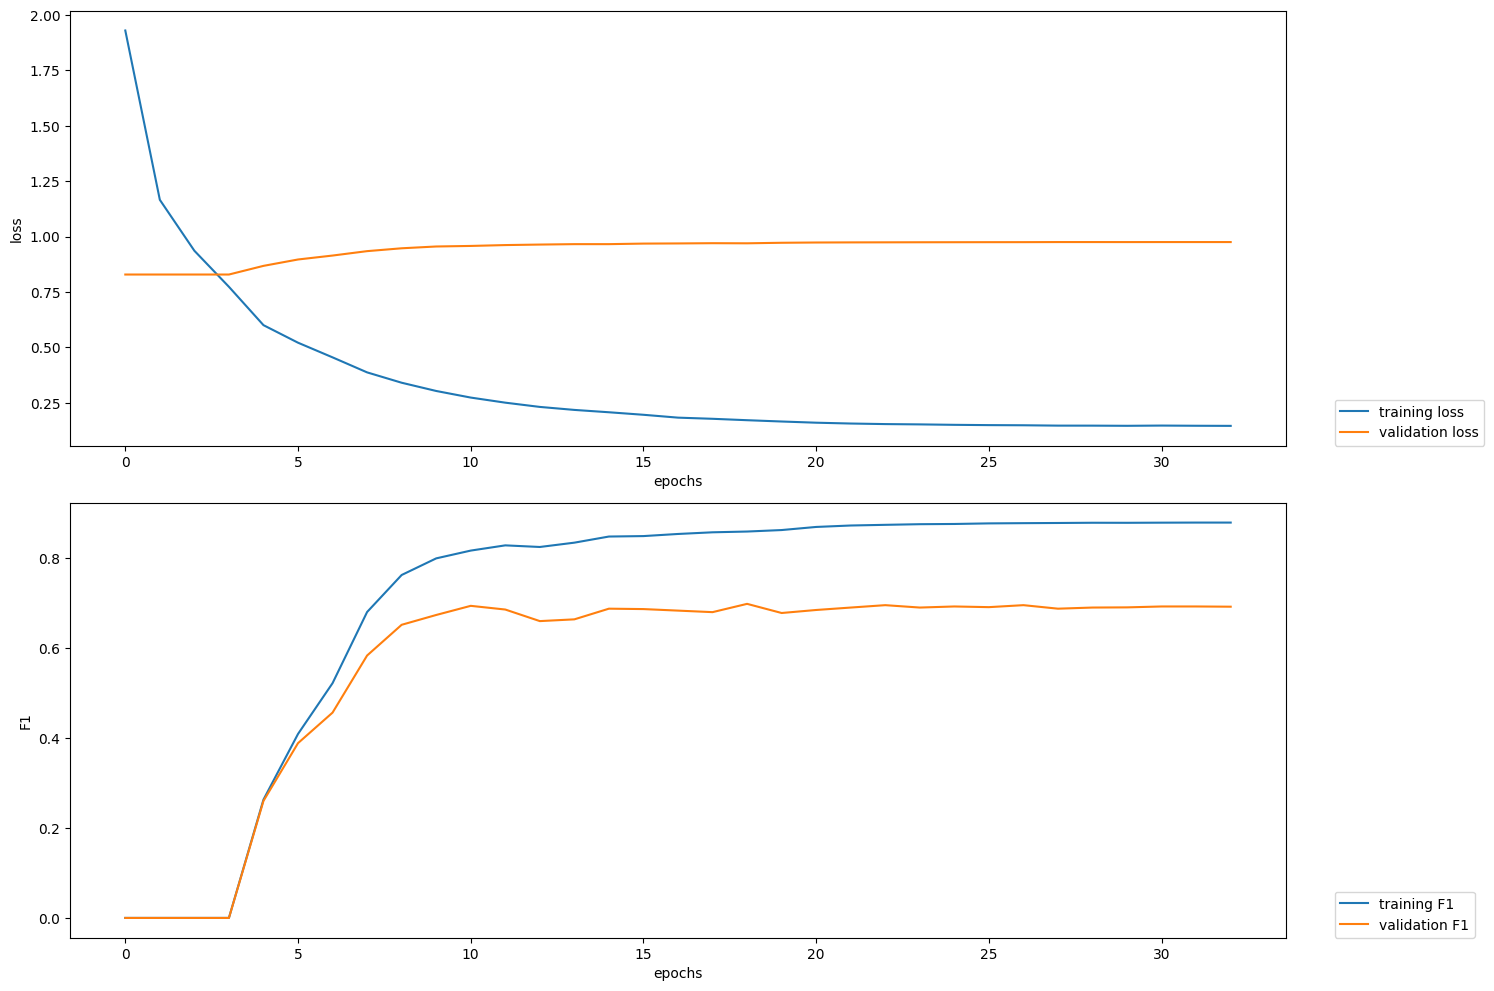

100%|██████████| 64/64 [00:24<00:00,  2.56it/s]


2023-04-21 15:56:18,571 Evaluating as a multi-label problem: True


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

2023-04-21 15:56:25,680 Evaluating as a multi-label problem: False



100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

2023-04-21 15:56:28,925 Evaluating as a multi-label problem: True


,split,index,I-ADR,E-ADR,B-ADR,S-ADR,S-Drug,B-Finding,E-Finding,I-Finding,...,B-Symptom,B-Drug,S-Finding,I-Symptom,I-Drug,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.873157,0.871623,0.856192,0.736933,0.727064,0.391304,0.384615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.836392,0.242044,0.757067,0.142355
1,train,recall,0.971679,0.966343,0.959988,0.941306,0.986003,0.045000,0.025000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.858097,0.244766,0.858097,0.142318
2,train,f1-score,0.919787,0.916543,0.905124,0.826675,0.836964,0.080717,0.046948,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.847105,0.226638,0.799225,0.142331
3,train,support,4449.000000,3506.000000,3349.000000,1363.000000,1286.000000,200.000000,200.000000,149.0,...,110.0,110.0,109.0,104.0,50.0,50.0,15722.000000,15722.000000,15722.000000,15722.000000
4,dev,precision,0.580189,0.730693,0.739044,0.678571,0.654472,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.671795,0.169148,0.582696,NaN
5,dev,recall,0.713733,0.821826,0.839367,0.818182,0.981707,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.697483,0.208741,0.697483,NaN
6,dev,f1-score,0.640069,0.773585,0.786017,0.741866,0.785366,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.684398,0.186345,0.633846,NaN
7,dev,support,517.000000,449.000000,442.000000,209.000000,164.000000,39.000000,34.000000,20.0,...,12.0,20.0,25.0,23.0,7.0,13.0,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.629338,0.775161,0.760171,0.631841,0.680000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.699609,0.173826,0.613960,0.120838
9,test,recall,0.760000,0.819005,0.849282,0.803797,0.973958,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.718954,0.210302,0.718954,0.120754


In [17]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=15,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=15,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=15,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [18]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.